In [1]:
# Commented out IPython magic to ensure Python compatibility.
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xvzf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
%cd /content  # Change this to the appropriate directory if needed
!pip install TA-Lib

--2023-11-18 17:48:09--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-11-18 17:48:10--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://nchc.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-11-18 17:48:10--  http://nchc.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving nchc.dl.sourceforge.n

In [2]:
## install required packages
!pip install swig
!pip install wrds
!pip install pyportfolioopt
## install finrl library
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.8 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.23
    Uninstalling SQLAlchemy-2.0.23:
      Successfully uninstalled SQLAlchemy-2.0.23
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.50 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.4 MB/s eta 0:00:00
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-or4yxdrx
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-or4yxdrx
  Resolved ht

In [3]:
import finrl
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import yfinance as yf
import os
import talib

/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/dtypes.py:35: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  from tensorflow.tsl.python.lib.core import pywrap_ml_dtypes


In [4]:
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl import config_tickers
from finrl.main import check_and_make_directories
from finrl.config import TRAINED_MODEL_DIR, RESULTS_DIR
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3
get_ipython().run_line_magic('matplotlib', 'inline')
from finrl.config import INDICATORS
from pypfopt.efficient_frontier import EfficientFrontier


check_and_make_directories([TRAINED_MODEL_DIR])


import itertools

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
config_tickers.DOW_30_TICKER

['AXP',
 'AMGN',
 'AAPL',
 'BA',
 'CAT',
 'CSCO',
 'CVX',
 'GS',
 'HD',
 'HON',
 'IBM',
 'INTC',
 'JNJ',
 'KO',
 'JPM',
 'MCD',
 'MMM',
 'MRK',
 'MSFT',
 'NKE',
 'PG',
 'TRV',
 'UNH',
 'CRM',
 'VZ',
 'V',
 'WBA',
 'WMT',
 'DIS',
 'DOW']

In [6]:
# Function to calculate KDJ
def calculate_kdj(df, n=9, m1=3, m2=3):
    low_list = df['low'].rolling(n).min()
    high_list = df['high'].rolling(n).max()
    rsv = (df['close'] - low_list) / (high_list - low_list) * 100
    k_values = rsv.ewm(span=m1, adjust=False).mean()
    d_values = k_values.ewm(span=m2, adjust=False).mean()
    j_values = 3 * k_values - 2 * d_values
    return k_values, d_values, j_values

In [7]:
TRAIN_START_DATE = '2013-01-01' #start date of training data
TRAIN_END_DATE = '2018-01-01'   #end date of training data
TRADE_START_DATE = '2018-01-01' #start date of trading data
TRADE_END_DATE = '2022-12-31'   #end date of trading data

In [8]:
df_raw = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = config_tickers.DOW_30_TICKER).fetch_data()
df_raw.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

,date,open,high,low,close,volume,tic,day
0,2013-01-02,19.779285,19.821428,19.343929,16.769093,560518000,AAPL,2
1,2013-01-02,87.360001,89.239998,87.290001,66.515770,5772800,AMGN,2
2,2013-01-02,58.330002,58.950001,58.310001,50.327694,6091400,AXP,2
3,2013-01-02,76.550003,77.330002,76.449997,64.583855,5036400,BA,2
4,2013-01-02,92.949997,94.440002,92.949997,69.443283,11590000,CAT,2


In [9]:
#Preprocess Data

fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_vix=True,
                     use_turbulence=True,
                     user_defined_feature = False)
processed = fe.preprocess_data(df_raw)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Successfully added technical indicators
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (2517, 8)
Successfully added vix
Successfully added turbulence index


In [10]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])
# Calculate KDJ and add to the dataframe
n = 9  # Period for calculating KDJ
m1 = 3  # Smoothing period for %K
m2 = 3  # Smoothing period for %D

k_values, d_values, j_values = calculate_kdj(processed_full, n, m1, m2)
processed_full['k_values'] = k_values
processed_full['d_values'] = d_values
processed_full['j_values'] = j_values

processed_full = processed_full.fillna(0)
processed_full.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,tic,open,high,low,close,volume,day,macd,boll_ub,...,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence,k_values,d_values,j_values
0,2013-01-02,AAPL,19.779285,19.821428,19.343929,16.769093,560518000.0,2.0,0.0,16.962602,...,0.0,-66.666667,100.0,16.769093,16.769093,14.68,0.0,0.0,0.0,0.0
1,2013-01-02,AMGN,87.360001,89.239998,87.290001,66.515770,5772800.0,2.0,0.0,16.962602,...,0.0,-66.666667,100.0,66.515770,66.515770,14.68,0.0,0.0,0.0,0.0
2,2013-01-02,AXP,58.330002,58.950001,58.310001,50.327694,6091400.0,2.0,0.0,16.962602,...,0.0,-66.666667,100.0,50.327694,50.327694,14.68,0.0,0.0,0.0,0.0
3,2013-01-02,BA,76.550003,77.330002,76.449997,64.583855,5036400.0,2.0,0.0,16.962602,...,0.0,-66.666667,100.0,64.583855,64.583855,14.68,0.0,0.0,0.0,0.0
4,2013-01-02,CAT,92.949997,94.440002,92.949997,69.443283,11590000.0,2.0,0.0,16.962602,...,0.0,-66.666667,100.0,69.443283,69.443283,14.68,0.0,0.0,0.0,0.0


In [12]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

train.to_csv('train_data.csv')
trade.to_csv('trade_data.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


36511
36482


In [13]:

train = pd.read_csv('train_data.csv')
train = train.set_index(train.columns[0])
train.index.names = ['']

#Construct the environment
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,  # Maximum number of trading days in each episode
    "initial_amount": 1000000,  # Initial capital
    "num_stock_shares": num_stock_shares,  # List to track the number of shares held
    "buy_cost_pct": buy_cost_list,  # Buying cost percentages for each stock
    "sell_cost_pct": sell_cost_list,  # Selling cost percentages for each stock
    "state_space": state_space,  # Size and configuration of the state space
    "stock_dim": stock_dimension,  # Number of different stocks
    "tech_indicator_list": INDICATORS,  # List of technical indicators
    "action_space": stock_dimension,  # Size of the action space (number of stocks to buy/sell)
    "reward_scaling": 1e-4  # Scaling factor for rewards
}
e_train_gym = StockTradingEnv(df = train, **env_kwargs)

#creating environment of training
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

#training DRL agents
agent = DRLAgent(env = env_train)

# Set the corresponding values to 'True' for the algorithms that you want to use
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Stock Dimension: 29, State Space: 291
<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [17]:
## Agent 1: A2C

agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)

trained_a2c = agent.train_model(model=model_a2c,
                             tb_log_name='a2c',
                             total_timesteps=50000) if if_using_a2c else None

trained_a2c.save(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c
--------------------------------------
| time/                 |            |
|    fps                | 99         |
|    iterations         | 100        |
|    time_elapsed       | 5          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -41.4      |
|    explained_variance | -0.124     |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | 146        |
|    reward             | 0.05502404 |
|    std                | 1.01       |
|    value_loss         | 13.9       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 88         |
|    iterations         | 200        |
|    time_elapsed       | 11         |
|    total_timesteps    | 1000       |
| train/                |            |
|    

In [14]:


"""### Agent 2: DDPG"""

agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

trained_ddpg = agent.train_model(model=model_ddpg,
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

trained_ddpg.save(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None

"""### Agent 3: PPO"""

agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=200000) if if_using_ppo else None

trained_ppo.save(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None

"""### Agent 4: TD3"""

agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100,
              "buffer_size": 1000000,
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

trained_td3 = agent.train_model(model=model_td3,
                             tb_log_name='td3',
                             total_timesteps=50000) if if_using_td3 else None

trained_td3.save(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None

"""### Agent 5: SAC"""

agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

trained_sac = agent.train_model(model=model_sac,
                             tb_log_name='sac',
                             total_timesteps=70000) if if_using_sac else None

trained_sac.save(TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Logging to results/ddpg
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 32         |
|    time_elapsed    | 153        |
|    total_timesteps | 5036       |
| train/             |            |
|    actor_loss      | 63.9       |
|    critic_loss     | 2.64e+03   |
|    learning_rate   | 0.001      |
|    n_updates       | 3777       |
|    reward          | -0.8756889 |
-----------------------------------
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 28         |
|    time_elapsed    | 352        |
|    total_timesteps | 10072      |
| train/             |            |
|    actor_loss      | 20.8       |
|    critic_loss     | 80.7       |
|    learning_rate   | 0.001      |
|    n_updates       | 8813       |
|    reward          | -0.8756889 |
-----------------------------------
day: 1258, episode: 10
begin_total_asset

Stock Dimension: 29, State Space: 291
hit end!
hit end!
hit end!
hit end!
hit end!
Metrics for A2C:
{'Cumulative Return': 0.4881115764052233, 'Annualized Return': 3.1926020453401454e+43, 'Sharpe Ratio': 0.4600570766563507, 'Max Drawdown': 0.0}
Metrics for DDPG:
{'Cumulative Return': 0.43594795412725396, 'Annualized Return': 3.971478355789816e+39, 'Sharpe Ratio': 0.4487613529668886, 'Max Drawdown': 0.0}
Metrics for PPO:
{'Cumulative Return': 0.04091051178608862, 'Annualized Return': 24443.174466265442, 'Sharpe Ratio': 0.1696356390246913, 'Max Drawdown': 0.0}
Metrics for TD3:
{'Cumulative Return': 0.5119635306123362, 'Annualized Return': 1.7555435174704467e+45, 'Sharpe Ratio': 0.5505469925028592, 'Max Drawdown': 0.0}
Metrics for SAC:
{'Cumulative Return': 0.5677921033708395, 'Annualized Return': 1.6319059003014549e+49, 'Sharpe Ratio': 0.5355964464829165, 'Max Drawdown': 0.0}
Mean returns of assets in k-portfolio 1
 [ 0.08   0.074  0.055  0.126  0.064  0.087  0.071  0.033  0.071  0.067
  

<ipython-input-23-f0423caf1383>:215: FutureWarning: Passing 'suffixes' which cause duplicate columns {'account_value_x'} in the result is deprecated and will raise a MergeError in a future version.
  if if_using_td3: result = pd.merge(result, df_result_td3, how='outer', left_index=True, right_index=True)


<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

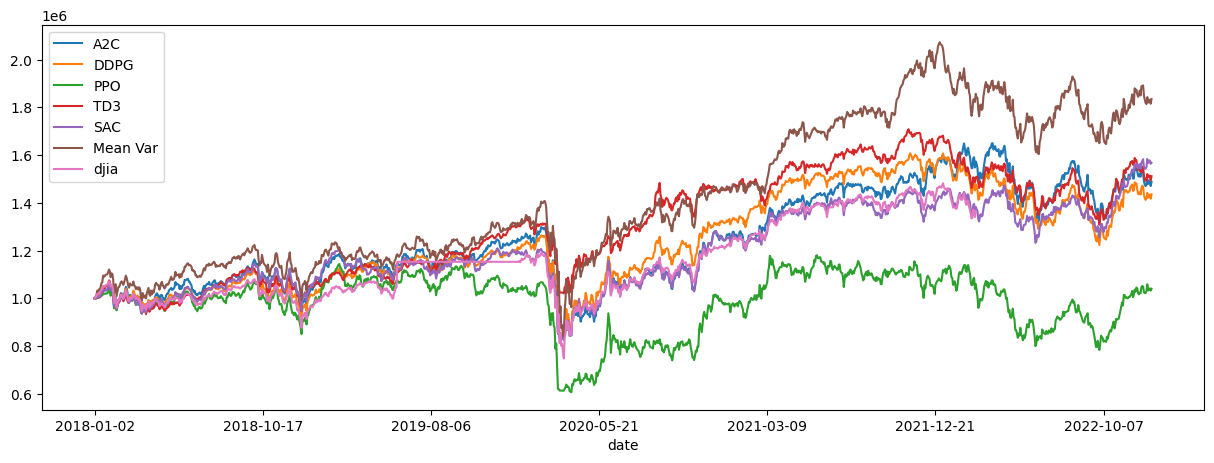

In [23]:
# # Part 2. Backtesting
train = pd.read_csv('train_data.csv')
trade = pd.read_csv('trade_data.csv')
train = train.set_index(train.columns[0])
train.index.names = ['']
trade = trade.set_index(trade.columns[0])
trade.index.names = ['']

if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

# Load the agents
trained_a2c = A2C.load("trained_models/agent_a2c") if if_using_a2c else None
trained_ddpg = DDPG.load("trained_models/agent_ddpg") if if_using_ddpg else None
trained_ppo = PPO.load("trained_models/agent_ppo") if if_using_ppo else None
trained_td3 = TD3.load("trained_models/agent_td3") if if_using_td3 else None
trained_sac = SAC.load("trained_models/agent_sac") if if_using_sac else None

stock_dimension = len(trade.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c,
    environment = e_trade_gym) if if_using_a2c else (None, None)

df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg,
    environment = e_trade_gym) if if_using_ddpg else (None, None)

df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo,
    environment = e_trade_gym) if if_using_ppo else (None, None)

df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3,
    environment = e_trade_gym) if if_using_td3 else (None, None)

df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac,
    environment = e_trade_gym) if if_using_sac else (None, None)

def calculate_metrics(account_value):
    if account_value.empty:
        return {
            'Cumulative Return': 0,
            'Annualized Return': 0,
            'Sharpe Ratio': 0,
            'Max Drawdown': 0
        }

    # Convert the 'account_value' DataFrame to numeric data type
    account_value_numeric = pd.to_numeric(account_value['account_value'], errors='coerce')

    daily_return = account_value_numeric.pct_change(1)

    if daily_return.empty:
        return {
            'Cumulative Return': 0,
            'Annualized Return': 0,
            'Sharpe Ratio': 0,
            'Max Drawdown': 0
        }

    cumulative_return = (1 + daily_return).cumprod() - 1
    cumulative_return.index = pd.to_datetime(cumulative_return.index)  # Convert index to DatetimeIndex
    annualized_return = (1 + cumulative_return.iloc[-1])**(252/len(cumulative_return.index.year.unique())) - 1  # Assuming 252 trading days in a year

    sharpe_ratio = (252**0.5) * daily_return.mean() / daily_return.std()

    max_drawdown = (1 - (1 + cumulative_return).cummax() / (1 + cumulative_return)).max()

    return {
        'Cumulative Return': cumulative_return.iloc[-1],
        'Annualized Return': annualized_return,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown
    }

# Evaluate A2C
metrics_a2c = calculate_metrics(df_account_value_a2c)
print("Metrics for A2C:")
print(metrics_a2c)

# Evaluate DDPG
metrics_ddpg = calculate_metrics(df_account_value_ddpg)
print("Metrics for DDPG:")
print(metrics_ddpg)

# Evaluate PPO
metrics_ppo = calculate_metrics(df_account_value_ppo)
print("Metrics for PPO:")
print(metrics_ppo)

# Evaluate TD3
metrics_td3 = calculate_metrics(df_account_value_td3)
print("Metrics for TD3:")
print(metrics_td3)

# Evaluate SAC
metrics_sac = calculate_metrics(df_account_value_sac)
print("Metrics for SAC:")
print(metrics_sac)


#Mean Variance Optimization
def process_df_for_mvo(df):
  df = df.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
  fst = df
  fst = fst.iloc[0:stock_dimension, :]
  tic = fst['tic'].tolist()

  mvo = pd.DataFrame()

  for k in range(len(tic)):
    mvo[tic[k]] = 0

  for i in range(df.shape[0]//stock_dimension):
    n = df
    n = n.iloc[i * stock_dimension:(i+1) * stock_dimension, :]
    date = n['date'][i*stock_dimension]
    mvo.loc[date] = n['close'].tolist()

  return mvo

#Helper functions for mean returns and variance-covariance matrix

def StockReturnsComputing(StockPrice, Rows, Columns):
  import numpy as np
  StockReturn = np.zeros([Rows-1, Columns])
  for j in range(Columns):        # j: Assets
    for i in range(Rows-1):     # i: Daily Prices
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100

  return StockReturn

# ### Calculate the weights for mean-variance
StockData = process_df_for_mvo(train)
TradeData = process_df_for_mvo(trade)

TradeData.to_numpy()

#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)

#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(29)])
mvo_weights

LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])

df_dji = YahooDownloader(start_date = TRADE_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = ['dji']).fetch_data()

df_dji = df_dji[['date','close']]
fst_day = df_dji['close'][0]
dji = pd.merge(df_dji['date'], df_dji['close'].div(fst_day).mul(1000000),
               how='outer', left_index=True, right_index=True).set_index('date')

df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0]) if if_using_a2c else None
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0]) if if_using_ddpg else None
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0]) if if_using_ppo else None
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0]) if if_using_td3 else None
df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0]) if if_using_sac else None
result = pd.DataFrame()

if if_using_a2c: result = pd.merge(result, df_result_a2c, how='outer', left_index=True, right_index=True)
if if_using_ddpg: result = pd.merge(result, df_result_ddpg, how='outer', left_index=True, right_index=True)
if if_using_ppo: result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True)
if if_using_td3: result = pd.merge(result, df_result_td3, how='outer', left_index=True, right_index=True)
if if_using_sac: result = pd.merge(result, df_result_sac, how='outer', left_index=True, right_index=True)
result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)
result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')

col_name = []
col_name.append('A2C') if if_using_a2c else None
col_name.append('DDPG') if if_using_ddpg else None
col_name.append('PPO') if if_using_ppo else None
col_name.append('TD3') if if_using_td3 else None
col_name.append('SAC') if if_using_sac else None
col_name.append('Mean Var')
col_name.append('djia')
result.columns = col_name
result

plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()
